In [107]:
import geopandas as gpd
import requests
from shapely.geometry import Point, LineString, MultiPoint, MultiLineString
from shapely.ops import linemerge, split
import numpy as np

import json
from shapely.geometry import mapping

In [111]:
gdf_dummy = gpd.GeoDataFrame(
                columns=["segment_id", "von_pkt_name", "von_pkt_geom", "bis_pkt_name", "bis_pkt_geom", "segment_geom"], 
                geometry="segment_geom", 
                crs='EPSG:4326')

gdf_dummy["segment_id"]     = gdf_dummy["segment_id"].astype("int16")
gdf_dummy["von_pkt_name"]   = gdf_dummy["von_pkt_name"].astype(str)
gdf_dummy["von_pkt_geom"]   = gdf_dummy["von_pkt_geom"].astype(Point)
gdf_dummy["bis_pkt_name"]   = gdf_dummy["bis_pkt_name"].astype(str)
gdf_dummy["bis_pkt_geom"]   = gdf_dummy["bis_pkt_geom"].astype(Point)
gdf_dummy["segment_geom"]  = gdf_dummy["segment_geom"].astype(LineString)

TypeError: dtype '<class 'shapely.geometry.point.Point'>' not understood

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

## Leere Spalten des GeoDataFrames
s_int16 = pd.Series(dtype="int16")
s_str   = pd.Series(dtype="str")
empty_point = gpd.GeoSeries([], dtype="geometry", crs="EPSG:4326")
empty_line  = gpd.GeoSeries([], dtype="geometry", crs="EPSG:4326")

## Zusammenbau des GeoDataFrames
gdf_dummy = gpd.GeoDataFrame(
    {
        "segment_id":   s_int16,
        "von_pkt_name": s_str,
        "von_pkt_geom": empty_point,
        "bis_pkt_name": s_str,
        "bis_pkt_geom": empty_point,
        "segment_geom": empty_line,
    },
    geometry="segment_geom", 
    crs="EPSG:4326"
)


In [118]:
gdf_dummy.geometry.info()

<class 'geopandas.geoseries.GeoSeries'>
RangeIndex: 0 entries
Series name: segment_geom
Non-Null Count  Dtype   
--------------  -----   
0 non-null      geometry
dtypes: geometry(1)
memory usage: 132.0 bytes


In [54]:
filepath = "../data/MeileBH_Buech.gpx"

In [31]:
# def to_3d_linestring_profile(line2d: LineString,
#                              crs: int = 2056,
#                              nb_points: int = 42,
#                              offset: int | None = None,
#                              distinct_points: bool = True,
#                              which: str = "COMB"):
#     """
#     Erzeugt einen 3D-LineString, indem es die Swisstopo-Profile-API in einem
#     einzigen Request nutzt (§ Profile API).
#     """

#     nb_points = len(line2d.coords)
#     # 1) GeoJSON aus der Shapely-Geometry erstellen
#     geom_geojson = mapping(line2d)

#     # 2) Parameter für den Request
#     url = "https://api3.geo.admin.ch/rest/services/profile.json"
#     params: dict[str, str] = {
#         "geom": json.dumps(geom_geojson),
#         "sr": str(crs),
#         "nb_points": str(nb_points),
#         "distinct_points": str(distinct_points).lower(),
#     }
#     if offset is not None:
#         params["offset"] = str(offset)

#     # 3) GET-Request an die Profile-API
#     r = requests.get(url, params=params, timeout=10)
#     r.raise_for_status()

#     # 4) JSON-Antwort parsen: Liste von Objekten mit
#     #    { "dist":…, "alts": { … }, "easting":…, "northing":… }
#     profile = r.json()

#     # 5) 3D-Koordinaten extrahieren (hier COMB-Höhe)
#     coords3d = [
#         (pt["easting"], pt["northing"], pt["alts"][which])
#         for pt in profile
#     ]

#     return LineString(coords3d)

In [55]:
import json
import requests
from shapely.geometry import mapping, LineString

def to_3d_linestring_profile(
    line2d: LineString,
    crs: int = 2056,
    offset: int | None = None,
    distinct_points: bool = True,
    which: str = "COMB",
    max_geom_chars: int = 3000  # Schwellenwert fürs GeoJSON im URL
) -> LineString:
    """
    Baut ein 3D-Linestring auf, auch wenn der ursprüngliche 2D-Linestring
    (im GeoJSON-Parameter) zu lang für einen einzigen GET-Request wäre.
    """
    coords = list(line2d.coords)
    geom = mapping(line2d)
    geom_str = json.dumps(geom)

    # 1) Falls zu lang, in Stücke teilen und rekursiv verarbeiten
    if len(geom_str) > max_geom_chars:
        # Abschätzen, wie viele Koordinaten pro Chunk
        n = len(coords)
        avg_chars_per_coord = len(geom_str) / n
        chunk_size = max(int(max_geom_chars / avg_chars_per_coord), 2)
        step = chunk_size - 1  # überlappend, damit keine Lücke entsteht

        # Teil-Linestrings erzeugen
        segments = []
        for i in range(0, n - 1, step):
            end = min(i + chunk_size, n)
            segments.append(LineString(coords[i:end]))

        # Für jedes Segment einmal abrufen
        seg3d_list = [
            to_3d_linestring_profile(
                seg,
                crs=crs,
                offset=offset,
                distinct_points=distinct_points,
                which=which,
                max_geom_chars=max_geom_chars
            )
            for seg in segments
        ]

        # 2) Jetzt die 3D-Segmente zu einem durchgehenden Linestring verbinden
        merged_coords = list(seg3d_list[0].coords)
        for seg3d in seg3d_list[1:]:
            # überschneidenden Startpunkt weglassen
            merged_coords.extend(seg3d.coords[1:])
        return LineString(merged_coords)

    # 3) Andernfalls wie gehabt in einem Request
    params = {
        "geom": json.dumps(geom),
        "sr": str(crs),
        "nb_points": str(len(coords)),
        "distinct_points": str(distinct_points).lower(),
    }
    if offset is not None:
        params["offset"] = str(offset)

    url = "https://api3.geo.admin.ch/rest/services/profile.json"
    r = requests.get(url, params=params, timeout=10)
    r.raise_for_status()
    profile = r.json()

    coords3d = [
        (pt["easting"], pt["northing"], pt["alts"][which])
        for pt in profile
    ]
    return LineString(coords3d)


In [56]:
def get_height(easting: float, 
               northing: float, 
               max_retries: int = 3):
    """
    Fragt die Höhe für einen Punkt (in LV95) bei der Swisstopo-API ab
    und gibt sie als float zurück.
    """
    HEIGHT_URL = "https://api3.geo.admin.ch/rest/services/height"
    params = {"easting": easting, "northing": northing}
    for attempt in range(max_retries):
        r = requests.get(HEIGHT_URL, params=params, timeout=5)
        if r.status_code == 200:
            return r.json()["height"]
    r.raise_for_status()


In [57]:
def to_3d_Point(pt: Point):
    z = get_height(pt.x, pt.y)
    return Point(pt.x, pt.y, z) 

In [58]:
def densify(linestring: LineString, 
            interval: float = 100.0):
    
    total_len = linestring.length
    orig_dists = [linestring.project(Point(x, y)) for x, y in linestring.coords]
    regular_dists = list(np.arange(0, total_len, interval))
    regular_dists.append(total_len)
    all_dists = sorted(set(orig_dists + regular_dists))
    pts = [linestring.interpolate(d) for d in all_dists]

    return LineString([(p.x, p.y) for p in pts])

In [59]:
def to_3d_linestring(line2d: LineString):

    coords2d = list(line2d.coords)
    coords3d = []
    for x, y in coords2d:
        z = get_height(x, y)
        coords3d.append((x, y, z))

    return LineString(coords3d)

In [ ]:

## Erstellung Waypoints GeoDataFrame
gdf_waypoints = gpd.read_file(filepath, layer="waypoints", driver="GPX")
gdf_waypoints['id'] = range(1, len(gdf_waypoints)+1)
gdf_waypoints = gdf_waypoints.set_crs(epsg=4326, allow_override=True).to_crs(epsg=2056)
gdf_waypoints["geometry"] = gdf_waypoints.geometry.apply(to_3d_Point)
# gdf_waypoints["geometry_2d"] = gdf_waypoints["geometry"]
gdf_waypoints = gdf_waypoints[["id","name", "geometry"]]
# gdf_waypoints = gdf_waypoints.set_geometry("geometry")

## Erstellung des MultiLine Tracks GeoDataFrame
gdf_routes = gpd.read_file(filepath, layer="routes", driver="GPX")
gdf_routes = gdf_routes.set_crs(epsg=4326, allow_override=True).to_crs(epsg=2056)
gdf_routes = gdf_routes[["geometry"]]
mls = MultiLineString(gdf_routes.geometry.tolist())
merged  = linemerge(mls)


# ## Aufteilen der Linie in Segmente gemäss den Waypoints
# points = gdf_waypoints.geometry.to_list()
# projected = [merged.interpolate(merged.project(pt)) for pt in points]
# print(projected)
# mp = MultiPoint(projected)
# print(mp)
# pieces = split(merged, mp)
# print(pieces)
# segments = list(pieces.geoms)
# gdf_lines = gpd.GeoDataFrame(
#     {'geometry': segments}
# )
# gdf_lines['id'] = range(1, len(gdf_lines)+1)

from shapely.ops import substring
import geopandas as gpd

## Aufteilen der Linie in Segmente gemäss den Waypoints v2
# Punkte projezieren
points = gdf_waypoints.geometry.to_list()
# Distanzen entlang der Linie zu den Waypoints
dists = sorted(merged.project(pt) for pt in points)
# Segmente der Linie zwischen den Waypoints
segments = [
    substring(merged, dists[i], dists[i+1])
    for i in range(len(dists) - 1)
    if dists[i+1] > dists[i]  # nur echte Stücke
]
# Erstellung GeoDataFrame
gdf_lines = gpd.GeoDataFrame(
    {
        'id':       range(1, len(segments) + 1),
        'geometry': segments
    },
    crs=gdf_routes.crs
)



# ## Weitere Stützpunkte den Linestrings hinzufügen
# gdf_lines['geometry'] = gdf_lines.geometry.apply(lambda ln: densify(ln, interval=100.0))

# ## Umdimensionierung der Segmente GeoDataFrame
# gdf_lines = gdf_lines[["id", "geometry"]]

# # ## Erstellung 3D-LineStrings
# gdf_lines_3d = gdf_lines.copy()
# gdf_lines_3d["geometry"] = [to_3d_linestring(line) for line in gdf_lines.geometry]


In [92]:
from shapely.geometry import MultiPoint

# Deine projektierten Punkte
projected = [merged.interpolate(merged.project(pt)) for pt in points]

# 1) Einzelpunkte testen
tol = 1e-8  # kleine Toleranz für numerische Ungenauigkeiten
on_line = [merged.distance(pt) < tol for pt in projected]
for i, pt in enumerate(projected):
    print(f"Punkt {i} auf Linie?  {on_line[i]} (distance = {merged.distance(pt)})")

# 2) Ganze MultiPoint‐Menge auf einmal
mp = MultiPoint(projected)
print("Alle Punkte auf Linie?", mp.distance(merged) < tol)

Punkt 0 auf Linie?  True (distance = 1.176435225420244e-11)
Punkt 1 auf Linie?  True (distance = 5.194462069076219e-11)
Punkt 2 auf Linie?  True (distance = 2.1329202065853673e-10)
Punkt 3 auf Linie?  True (distance = 1.227075023010028e-10)
Punkt 4 auf Linie?  True (distance = 0.0)
Alle Punkte auf Linie? True


In [102]:
gdf_waypoints

,id,name,geometry
0,1,Bahnhof,POINT Z (2691200.518 1236128.631 419.8)
1,2,Burg,POINT Z (2691059.111 1237140.363 505.2)
2,3,Übereschüttle,POINT Z (2691362.298 1238028.098 609.4)
3,4,Ratsfelse,POINT Z (2691110.641 1238243.144 614.2)
4,5,Buech,POINT Z (2690090.829 1238274.891 584.4)


<Axes: >

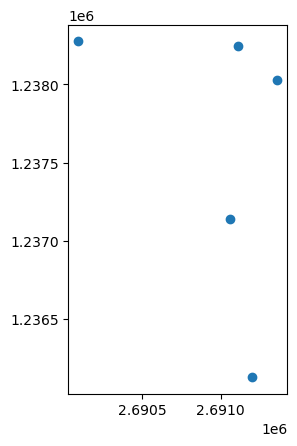

In [94]:
gdf_waypoints.plot()

<Axes: >

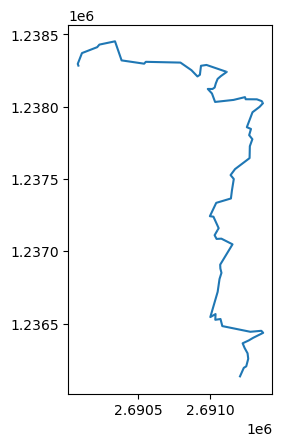

In [105]:
gdf_lines.plot()


In [40]:
gdf_lines_3d = gdf_lines.copy()
gdf_lines_3d["geometry"] = [to_3d_linestring(line) for line in gdf_lines.geometry]

In [41]:
gdf_lines_3d

,id,geometry
0,1,"LINESTRING Z (2771363.006 1182944.671 1619.8, ..."
1,2,"LINESTRING Z (2771631.169 1182149.947 1642.7, ..."
2,3,"LINESTRING Z (2771672.973 1181859.38 1660.2, 2..."
3,4,"LINESTRING Z (2772048.846 1181239.261 1952.8, ..."
4,5,"LINESTRING Z (2772884.396 1180425.213 2271.4, ..."
5,6,"LINESTRING Z (2773192.438 1181617.741 2428.5, ..."
6,7,"LINESTRING Z (2773796.352 1182123.088 2315.5, ..."
7,8,"LINESTRING Z (2772192.138 1182893.917 1664, 27..."


In [42]:
gdf_lines = gdf_lines.copy()

gdf_lines_3d["length_m"] = gdf_lines_3d.geometry.length
gdf_lines_3d["wkt_length"] = gdf_lines_3d.geometry.apply(lambda geom: len(geom.wkt))

gdf_lines_3d

,id,geometry,length_m,wkt_length
0,1,"LINESTRING Z (2771363.006 1182944.671 1619.8, ...",878.454958,999
1,2,"LINESTRING Z (2771631.169 1182149.947 1642.7, ...",323.576270,594
2,3,"LINESTRING Z (2771672.973 1181859.38 1660.2, 2...",1466.104433,2320
3,4,"LINESTRING Z (2772048.846 1181239.261 1952.8, ...",1567.294669,2670
4,5,"LINESTRING Z (2772884.396 1180425.213 2271.4, ...",1521.754011,2028
5,6,"LINESTRING Z (2773192.438 1181617.741 2428.5, ...",951.902648,1181
6,7,"LINESTRING Z (2773796.352 1182123.088 2315.5, ...",2853.694194,4822
7,8,"LINESTRING Z (2772192.138 1182893.917 1664, 27...",1066.285269,1364


In [48]:
gdf_lines_v2 = gdf_lines.copy()

gdf_lines_3d_v2 = gdf_lines_v2.copy()
gdf_lines_3d_v2["geometry"] = gdf_lines_v2.geometry.apply(
    lambda ln: to_3d_linestring_profile(ln)
)

In [49]:
gdf_lines_3d_v2

,id,geometry
0,1,"LINESTRING Z (2771363.006 1182944.671 1619.8, ..."
1,2,"LINESTRING Z (2771631.169 1182149.947 1642.7, ..."
2,3,"LINESTRING Z (2771672.973 1181859.38 1660.2, 2..."
3,4,"LINESTRING Z (2772048.846 1181239.261 1952.8, ..."
4,5,"LINESTRING Z (2772884.396 1180425.213 2271.4, ..."
5,6,"LINESTRING Z (2773192.438 1181617.741 2428.5, ..."
6,7,"LINESTRING Z (2773796.352 1182123.088 2315.5, ..."
7,8,"LINESTRING Z (2772192.138 1182893.917 1664, 27..."


<Axes: >

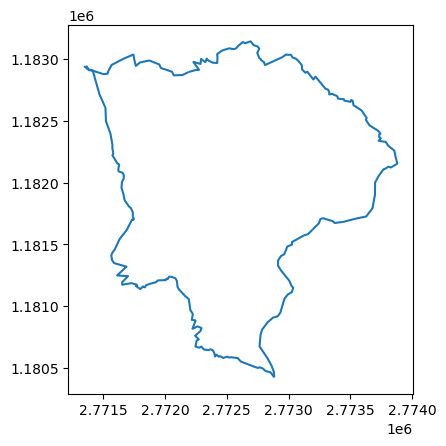

In [50]:
gdf_lines_3d_v2.plot()

In [ ]:
def combine_waypoints_lines(gdf_lines: gpd.GeoDataFrame,
                            gdf_waypoints: gpd.GeoDataFrame):

    ## Lines GeoDataFrame unbennene und angleichen an Waypoints GeoDataFrame
    gdf = (
        gdf_lines
        .rename(columns={"id": "segment_id"})
        .copy()
        .set_geometry("geometry")
        .rename_geometry("segment_geom")
        .to_crs(gdf_waypoints.crs)
    )

    ## Start und endpunkt extrahieren
    gdf["von_pkt_geom"] = gdf.segment_geom.apply(lambda ln: Point(*ln.coords[0]))
    gdf["bis_pkt_geom"] = gdf.segment_geom.apply(lambda ln: Point(*ln.coords[-1]))

    ## Erstellung der GeoDataFrames der Start und Endpunkte der Linien
    gdf_v = gdf[["segment_id", "von_pkt_geom"]].set_geometry("von_pkt_geom")
    gdf_b = gdf[["segment_id", "bis_pkt_geom"]].set_geometry("bis_pkt_geom")
    gdf_v.crs = gdf.crs
    gdf_b.crs = gdf.crs

    ## Joins erstellen
    sj_v = (
        gpd.sjoin_nearest(
            gdf_v,
            gdf_waypoints[["id", "name", "geometry"]],
            how="left"
        )
        .rename(columns={"id": "von_pkt_id", "name": "von_pkt_name"})
        .drop(columns=["index_right"])
    )

    sj_b = (
        gpd.sjoin_nearest(
            gdf_b,
            gdf_waypoints[["id", "name", "geometry"]],
            how="left"
        )
        .rename(columns={"id": "bis_pkt_id", "name": "bis_pkt_name"})
        .drop(columns=["index_right"])
    )

    ## Merge der Waypoints in die Linien GeoDataFrame
    df = (
        gdf
        .merge(sj_v[["segment_id", "von_pkt_name"]], on="segment_id", how="left")
        .merge(sj_b[["segment_id", "bis_pkt_name"]], on="segment_id", how="left")
    )

    ## Resultat-GeoDataFrame
    out = df[[
        "segment_id",
        "von_pkt_name", "von_pkt_geom",
        "bis_pkt_name", "bis_pkt_geom",
        "segment_geom"
    ]]

    out["segment_id"]     = out["segment_id"].astype("Int32")
    out["von_pkt_name"]   = out["von_pkt_name"].astype(str)
    out["bis_pkt_name"]   = out["bis_pkt_name"].astype(str)

    return gpd.GeoDataFrame(out, geometry="segment_geom", crs=gdf.crs)


In [ ]:
gdf_waypoints = gdf_waypoints.set_crs(epsg=2056, allow_override=True)
gdf_lines_3d = gdf_lines_3d.set_crs(epsg=2056, allow_override=True)

In [ ]:
res = combine_waypoints_lines(gdf_lines_3d, gdf_waypoints)

c:\Users\r.boppart\anaconda3\envs\4040Hackathon_py313\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\r.boppart\anaconda3\envs\4040Hackathon_py313\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\r.boppart\anaconda3\envs\4040Hackathon_py313\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying t

In [ ]:
res

,segment_id,von_pkt_name,von_pkt_geom,bis_pkt_name,bis_pkt_geom,segment_geom
0,1,Start - Arosa Isel,POINT Z (2771363.006 1182944.671 1619.8),Talboden,POINT Z (2771631.169 1182149.947 1642.7),"LINESTRING Z (2771363.006 1182944.671 1619.8, ..."
1,2,Talboden,POINT Z (2771631.169 1182149.947 1642.7),Wasserfall,POINT Z (2771672.973 1181859.38 1660.2),"LINESTRING Z (2771631.169 1182149.947 1642.7, ..."
2,3,Wasserfall,POINT Z (2771672.973 1181859.38 1660.2),Sattel Alteiner,POINT Z (2772048.846 1181239.261 1952.8),"LINESTRING Z (2771672.973 1181859.38 1660.2, 2..."
3,4,Sattel Alteiner,POINT Z (2772048.846 1181239.261 1952.8),Altein,POINT Z (2772884.396 1180425.213 2271.4),"LINESTRING Z (2772048.846 1181239.261 1952.8, ..."
4,5,Altein,POINT Z (2772884.396 1180425.213 2271.4),Schiesshornbode,POINT Z (2773192.438 1181617.741 2428.5),"LINESTRING Z (2772884.396 1180425.213 2271.4, ..."
5,6,Schiesshornbode,POINT Z (2773192.438 1181617.741 2428.5),Obersäss Sattel,POINT Z (2773796.352 1182123.088 2315.5),"LINESTRING Z (2773192.438 1181617.741 2428.5, ..."
6,7,Obersäss Sattel,POINT Z (2773796.352 1182123.088 2315.5),Talboden,POINT Z (2772192.138 1182893.917 1664),"LINESTRING Z (2773796.352 1182123.088 2315.5, ..."
7,8,Talboden,POINT Z (2772192.138 1182893.917 1664),Ende Arosa Isel,POINT Z (2771346.867 1182941.387 1619.9),"LINESTRING Z (2772192.138 1182893.917 1664, 27..."


In [51]:
res2 = res.copy()

res2 = res2.sort_values("von_pkt_name")

res2.reset_index()

,index,segment_id,von_pkt_name,von_pkt_geom,bis_pkt_name,bis_pkt_geom,segment_geom
0,4,5,Altein,POINT Z (2772884.396 1180425.213 2271.4),Schiesshornbode,POINT Z (2773192.438 1181617.741 2428.5),"LINESTRING Z (2772884.396 1180425.213 2271.4, ..."
1,6,7,Obersäss Sattel,POINT Z (2773796.352 1182123.088 2315.5),Talboden,POINT Z (2772192.138 1182893.917 1664),"LINESTRING Z (2773796.352 1182123.088 2315.5, ..."
2,3,4,Sattel Alteiner,POINT Z (2772048.846 1181239.261 1952.8),Altein,POINT Z (2772884.396 1180425.213 2271.4),"LINESTRING Z (2772048.846 1181239.261 1952.8, ..."
3,5,6,Schiesshornbode,POINT Z (2773192.438 1181617.741 2428.5),Obersäss Sattel,POINT Z (2773796.352 1182123.088 2315.5),"LINESTRING Z (2773192.438 1181617.741 2428.5, ..."
4,0,1,Start - Arosa Isel,POINT Z (2771363.006 1182944.671 1619.8),Talboden,POINT Z (2771631.169 1182149.947 1642.7),"LINESTRING Z (2771363.006 1182944.671 1619.8, ..."
5,1,2,Talboden,POINT Z (2771631.169 1182149.947 1642.7),Wasserfall,POINT Z (2771672.973 1181859.38 1660.2),"LINESTRING Z (2771631.169 1182149.947 1642.7, ..."
6,7,8,Talboden,POINT Z (2772192.138 1182893.917 1664),Ende Arosa Isel,POINT Z (2771346.867 1182941.387 1619.9),"LINESTRING Z (2772192.138 1182893.917 1664, 27..."
7,2,3,Wasserfall,POINT Z (2771672.973 1181859.38 1660.2),Sattel Alteiner,POINT Z (2772048.846 1181239.261 1952.8),"LINESTRING Z (2771672.973 1181859.38 1660.2, 2..."


In [53]:
from collections import defaultdict, deque

# 1. Start und Ende ermitteln wie gehabt
all_vons = set(res2['von_pkt_name'])
all_bis  = set(res2['bis_pkt_name'])
start = (all_vons - all_bis).pop()
end   = (all_bis  - all_vons).pop()

# 2. Mapping von jedem Start‐Knoten auf eine Queue aller passenden Zeilen
von_index = defaultdict(deque)
for idx, row in res2.iterrows():
    von_index[row.von_pkt_name].append(idx)

# 3. Pfad in richtiger Reihenfolge ablaufen
ordered_idx = []
current = start
while von_index[current]:
    idx = von_index[current].popleft()   # erst erstes Talboden‐Segment, dann das zweite
    ordered_idx.append(idx)
    current = res2.at[idx, 'bis_pkt_name']

# 4. Neu sortieren und segment_id neu vergeben
gdf_sorted = (
    res2
    .loc[ordered_idx]
    .reset_index(drop=True)
    .assign(segment_id=lambda df: df.index + 1)
    .set_geometry('segment_geom')
)

gdf_sorted

,segment_id,von_pkt_name,von_pkt_geom,bis_pkt_name,bis_pkt_geom,segment_geom
0,1,Start - Arosa Isel,POINT Z (2771363.006 1182944.671 1619.8),Talboden,POINT Z (2771631.169 1182149.947 1642.7),"LINESTRING Z (2771363.006 1182944.671 1619.8, ..."
1,2,Talboden,POINT Z (2771631.169 1182149.947 1642.7),Wasserfall,POINT Z (2771672.973 1181859.38 1660.2),"LINESTRING Z (2771631.169 1182149.947 1642.7, ..."
2,3,Wasserfall,POINT Z (2771672.973 1181859.38 1660.2),Sattel Alteiner,POINT Z (2772048.846 1181239.261 1952.8),"LINESTRING Z (2771672.973 1181859.38 1660.2, 2..."
3,4,Sattel Alteiner,POINT Z (2772048.846 1181239.261 1952.8),Altein,POINT Z (2772884.396 1180425.213 2271.4),"LINESTRING Z (2772048.846 1181239.261 1952.8, ..."
4,5,Altein,POINT Z (2772884.396 1180425.213 2271.4),Schiesshornbode,POINT Z (2773192.438 1181617.741 2428.5),"LINESTRING Z (2772884.396 1180425.213 2271.4, ..."
5,6,Schiesshornbode,POINT Z (2773192.438 1181617.741 2428.5),Obersäss Sattel,POINT Z (2773796.352 1182123.088 2315.5),"LINESTRING Z (2773192.438 1181617.741 2428.5, ..."
6,7,Obersäss Sattel,POINT Z (2773796.352 1182123.088 2315.5),Talboden,POINT Z (2772192.138 1182893.917 1664),"LINESTRING Z (2773796.352 1182123.088 2315.5, ..."
7,8,Talboden,POINT Z (2772192.138 1182893.917 1664),Ende Arosa Isel,POINT Z (2771346.867 1182941.387 1619.9),"LINESTRING Z (2772192.138 1182893.917 1664, 27..."


In [52]:

# 1. Start- und Endknoten ermitteln
all_vons = set(res2['von_pkt_name'])
all_bis  = set(res2['bis_pkt_name'])
start = (all_vons - all_bis).pop()
end   = (all_bis  - all_vons).pop()

# 2. Lookup: von_name → Zeilenindex
von_index = {row.von_pkt_name: idx for idx, row in res2.iterrows()}

# 3. In Topologie-Reihenfolge laufen
ordered_idx = []
current = start
while current in von_index:
    idx = von_index[current]
    ordered_idx.append(idx)
    current = res2.at[idx, 'bis_pkt_name']
# wenn current==end, ist current nicht mehr in von_index und loop endet

# 4. Neu sortieren und segment_id neu vergeben
gdf_sorted = res2.loc[ordered_idx].reset_index(drop=True)
gdf_sorted['segment_id'] = gdf_sorted.index + 1
gdf_sorted = gdf_sorted.set_geometry('segment_geom')


# Ergebnis
gdf_sorted

,segment_id,von_pkt_name,von_pkt_geom,bis_pkt_name,bis_pkt_geom,segment_geom
0,1,Start - Arosa Isel,POINT Z (2771363.006 1182944.671 1619.8),Talboden,POINT Z (2771631.169 1182149.947 1642.7),"LINESTRING Z (2771363.006 1182944.671 1619.8, ..."
1,2,Talboden,POINT Z (2772192.138 1182893.917 1664),Ende Arosa Isel,POINT Z (2771346.867 1182941.387 1619.9),"LINESTRING Z (2772192.138 1182893.917 1664, 27..."


<Axes: >

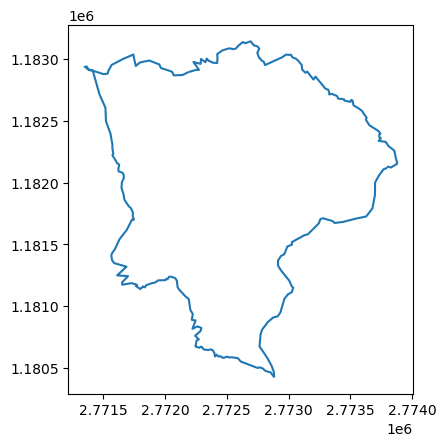

In [ ]:
gdf_lines_3d.plot()

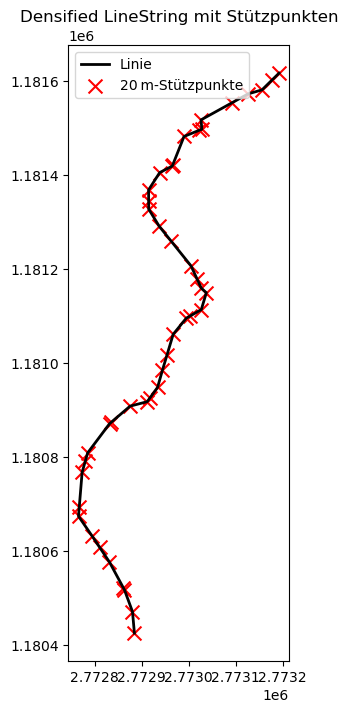

In [ ]:
import matplotlib.pyplot as plt

# 1) Deinen (bereits densified) LineString holen
dense_line0 = gdf_lines.geometry.iloc[4]

# 2) Koordinaten extrahieren
# Variante a: mit coords
coords = list(dense_line0.coords)     # [(x1,y1), (x2,y2), ...]
x_pts, y_pts = zip(*coords)

# Variante b: mit .xy
# x_pts, y_pts = dense_line0.xy

# 3) Plotten
fig, ax = plt.subplots(figsize=(6,8))
#    erst die Linie
x_line, y_line = dense_line0.xy
ax.plot(x_line, y_line, '-', lw=2, color='black', label='Linie')
#    dann die Punkte
ax.scatter(x_pts, y_pts, s=100, c='red', marker='x', label='20 m-Stützpunkte')

ax.set_aspect('equal')
ax.set_title("Densified LineString mit Stützpunkten")
ax.legend()
plt.show()


## Andere API

In [ ]:
import json
from shapely.geometry import mapping

In [ ]:
def to_3d_linestring_profile(line2d: LineString,
                             crs: int = 2056,
                             nb_points: int = 42,
                             offset: int | None = None,
                             distinct_points: bool = True,
                             which: str = "COMB"):
    """
    Erzeugt einen 3D-LineString, indem es die Swisstopo-Profile-API in einem
    einzigen Request nutzt (§ Profile API).
    """

    nb_points = len(line2d.coords)
    # 1) GeoJSON aus der Shapely-Geometry erstellen
    geom_geojson = mapping(line2d)

    # 2) Parameter für den Request
    url = "https://api3.geo.admin.ch/rest/services/profile.json"
    params: dict[str, str] = {
        "geom": json.dumps(geom_geojson),
        "sr": str(crs),
        "nb_points": str(nb_points),
        "distinct_points": str(distinct_points).lower(),
    }
    if offset is not None:
        params["offset"] = str(offset)

    # 3) GET-Request an die Profile-API
    r = requests.get(url, params=params, timeout=10)
    r.raise_for_status()

    # 4) JSON-Antwort parsen: Liste von Objekten mit
    #    { "dist":…, "alts": { … }, "easting":…, "northing":… }
    profile = r.json()

    # 5) 3D-Koordinaten extrahieren (hier COMB-Höhe)
    coords3d = [
        (pt["easting"], pt["northing"], pt["alts"][which])
        for pt in profile
    ]

    return LineString(coords3d)

In [ ]:

## Erstellung Waypoints GeoDataFrame
gdf_waypoints_v2 = gpd.read_file(filepath, layer="waypoints", driver="GPX")
gdf_waypoints_v2['id'] = range(1, len(gdf_waypoints_v2)+1)
gdf_waypoints_v2 = gdf_waypoints_v2.set_crs(epsg=4326, allow_override=True).to_crs(epsg=2056)
gdf_waypoints_v2["geometry"] = gdf_waypoints_v2.geometry.apply(to_3d_Point)
gdf_waypoints_v2 = gdf_waypoints_v2[["id","name", "geometry"]]

## Erstellung des MultiLine Tracks GeoDataFrame
gdf_routes_v2 = gpd.read_file(filepath, layer="routes", driver="GPX")
gdf_routes_v2 = gdf_routes_v2.set_crs(epsg=4326, allow_override=True).to_crs(epsg=2056)
gdf_routes_v2 = gdf_routes_v2[["geometry"]]
mls_v2 = MultiLineString(gdf_routes_v2.geometry.tolist())
merged_v2  = linemerge(mls_v2)


## Aufteilen der Linie in Segmente gemäss den Waypoints
points_v2 = gdf_waypoints_v2.geometry.to_list()
projected_v2 = [merged_v2.interpolate(merged_v2.project(pt)) for pt in points_v2]
mp_v2 = MultiPoint(projected_v2)
pieces_v2 = split(merged_v2, mp_v2)
segments_v2 = list(pieces_v2.geoms)
gdf_lines_v2 = gpd.GeoDataFrame(
    {'geometry': segments_v2}
)
gdf_lines_v2['id'] = range(1, len(gdf_lines_v2)+1)

## Weitere Stützpunkte den Linestrings hinzufügen
gdf_lines_v2['geometry'] = gdf_lines_v2.geometry.apply(lambda ln: densify(ln, interval=100.0))

## Umdimensionierung der Segmente GeoDataFrame
gdf_lines_v2 = gdf_lines_v2[["id", "geometry"]]

## Erstellung 3D-LineStrings via Profile-API (nur 1 Request pro Segment)
gdf_lines_3d_v2 = gdf_lines_v2.copy()
gdf_lines_3d_v2["geometry"] = gdf_lines_v2.geometry.apply(
    lambda ln: to_3d_linestring_profile(ln)
)

HTTPError: 400 Client Error: Bad Request for url: https://api3.geo.admin.ch/rest/services/profile.json?geom=%7B%22type%22%3A+%22LineString%22%2C+%22coordinates%22%3A+%5B%5B2773796.3515946334%2C+1182123.0882057052%5D%2C+%5B2773807.195880802%2C+1182128.2494628062%5D%2C+%5B2773826.6845268235%2C+1182121.4662200408%5D%2C+%5B2773877.7363060573%2C+1182151.5668597515%5D%2C+%5B2773876.582224074%2C+1182159.5739049802%5D%2C+%5B2773874.5588094164%2C+1182173.6123987022%5D%2C+%5B2773868.415649252%2C+1182193.538174298%5D%2C+%5B2773855.2072751652%2C+1182257.1464530323%5D%2C+%5B2773854.8583302596%2C+1182258.8268858162%5D%2C+%5B2773806.984047636%2C+1182295.922744649%5D%2C+%5B2773786.494340774%2C+1182327.5916105388%5D%2C+%5B2773785.588903626%2C+1182328.9910530888%5D%2C+%5B2773728.605797329%2C+1182337.4701065521%5D%2C+%5B2773746.3997784695%2C+1182357.6078584741%5D%2C+%5B2773734.758383337%2C+1182365.1107757296%5D%2C+%5B2773733.901625042%2C+1182365.662959254%5D%2C+%5B2773732.630626382%2C+1182386.6486165216%5D%2C+%5B2773743.222281824%2C+1182395.1276699654%5D%2C+%5B2773725.4283006685%2C+1182417.5971615978%5D%2C+%5B2773695.277901877%2C+1182436.7644834875%5D%2C+%5B2773653.405043627%2C+1182463.3840502158%5D%2C+%5B2773626.265124304%2C+1182505.8314195648%5D%2C+%5B2773624.8075739094%2C+1182508.111057143%5D%2C+%5B2773631.586233389%2C+1182523.585329673%5D%2C+%5B2773611.6739211436%2C+1182550.718300702%5D%2C+%5B2773593.6681068772%2C+1182579.7590587523%5D%2C+%5B2773583.53259224%2C+1182587.20224787%5D%2C+%5B2773567.400801367%2C+1182599.0489053472%5D%2C+%5B2773525.0341795785%2C+1182624.4860656888%5D%2C+%5B2773519.4654566064%2C+1182654.5437290801%5D%2C+%5B2773518.0436869725%2C+1182662.2178535236%5D%2C+%5B2773506.3928659805%2C+1182667.941214596%5D%2C+%5B2773499.8260396104%2C+1182652.4669420652%5D%2C+%5B2773451.951756995%2C+1182662.429829876%5D%2C+%5B2773447.715094814%2C+1182673.6645756874%5D%2C+%5B2773446.2258193567%2C+1182673.8221385854%5D%2C+%5B2773399.628979092%2C+1182678.7520077738%5D%2C+%5B2773394.7568175816%2C+1182695.7101146623%5D%2C+%5B2773386.9189925496%2C+1182702.4933574207%5D%2C+%5B2773365.9475147664%2C+1182709.4885765163%5D%2C+%5B2773363.466804971%2C+1182711.2215637267%5D%2C+%5B2773354.720359992%2C+1182717.33170096%5D%2C+%5B2773328.0293882727%2C+1182712.6682215733%5D%2C+%5B2773329.5122200297%2C+1182727.7185414333%5D%2C+%5B2773319.979730121%2C+1182751.2479147462%5D%2C+%5B2773299.4111356526%2C+1182758.241968673%5D%2C+%5B2773298.160919902%2C+1182758.6670865095%5D%2C+%5B2773235.549157007%2C+1182834.9390181315%5D%2C+%5B2773217.827237042%2C+1182856.5273747798%5D%2C+%5B2773200.6924519744%2C+1182832.8653835615%5D%2C+%5B2773174.46901353%2C+1182866.760226791%5D%2C+%5B2773151.344270936%2C+1182896.6498816737%5D%2C+%5B2773136.2656600713%2C+1182887.7337690424%5D%2C+%5B2773109.8780910466%2C+1182913.7962521405%5D%2C+%5B2773109.0938159553%2C+1182921.3589219984%5D%2C+%5B2773106.108438318%2C+1182950.146557507%5D%2C+%5B2773081.091652097%2C+1182982.0388065658%5D%2C+%5B2773059.159127194%2C+1183001.2427414851%5D%2C+%5B2773057.88130102%2C+1183001.744505976%5D%2C+%5B2773032.0861667716%2C+1183011.873491175%5D%2C+%5B2773018.3783387034%2C+1183033.4779179583%5D%2C+%5B2772998.8446837175%2C+1183032.792063145%5D%2C+%5B2772978.6256373283%2C+1183034.8496276%5D%2C+%5B2772973.121764979%2C+1183030.801878018%5D%2C+%5B2772950.18189411%2C+1183013.9310556534%5D%2C+%5B2772885.086922846%2C+1182984.2936103647%5D%2C+%5B2772809.333960812%2C+1182949.8036301997%5D%2C+%5B2772804.103911593%2C+1182965.7319336464%5D%2C+%5B2772801.451959669%2C+1182973.8085488381%5D%2C+%5B2772777.463260558%2C+1182990.2690644888%5D%2C+%5B2772772.3228250314%2C+1183001.5856689932%5D%2C+%5B2772763.4127367907%2C+1183006.043725311%5D%2C+%5B2772748.8746360056%2C+1183043.3227970966%5D%2C+%5B2772746.963343104%2C+1183048.223796638%5D%2C+%5B2772763.0700410632%2C+1183083.2023923642%5D%2C+%5B2772748.3775532558%2C+1183100.7885322825%5D%2C+%5B2772717.6267539477%2C+1183110.9206414914%5D%2C+%5B2772717.0433689095%2C+1183111.6547884177%5D%2C+%5B2772692.8761105957%2C+1183142.0674957081%5D%2C+%5B2772650.8750188686%2C+1183127.0569635716%5D%2C+%5B2772635.566035911%2C+1183133.3488328427%5D%2C+%5B2772629.8744729995%2C+1183135.6880195728%5D%2C+%5B2772591.998488501%2C+1183104.916428674%5D%2C+%5B2772575.498059613%2C+1183085.0274735768%5D%2C+%5B2772559.372640468%2C+1183078.6479974191%5D%2C+%5B2772557.5324220043%2C+1183078.932587109%5D%2C+%5B2772518.121568229%2C+1183085.0274736024%5D%2C+%5B2772464.495174326%2C+1183068.5158882511%5D%2C+%5B2772461.2290052962%2C+1183066.1897457838%5D%2C+%5B2772422.8690923518%2C+1183038.8700872674%5D%2C+%5B2772425.119150848%2C+1183007.723233051%5D%2C+%5B2772423.9284750475%2C+1182986.0779973818%5D%2C+%5B2772422.8690923764%2C+1182966.8195329353%5D%2C+%5B2772387.993185847%2C+1182969.0711127673%5D%2C+%5B2772351.992250071%2C+1182985.9579614548%5D%2C+%5B2772348.142682299%2C+1182990.5591652128%5D%2C+%5B2772338.491899152%2C+1183002.0942835216%5D%2C+%5B2772327.2416067333%2C+1182973.199009132%5D%2C+%5B2772292.3657001965%2C+1182999.467440407%5D%2C+%5B2772291.3140858584%2C+1182989.231184521%5D%2C+%5B2772288.2405929863%2C+1182959.314266909%5D%2C+%5B2772230.864101597%2C+1182975.0753256811%5D%2C+%5B2772236.8725904413%2C+1182966.557544566%5D%2C+%5B2772275.8652713313%2C+1182911.2805640274%5D%2C+%5B2772250.739618242%2C+1182910.5300374296%5D%2C+%5B2772243.796047629%2C+1182908.5616003869%5D%2C+%5B2772192.1375597767%2C+1182893.916904346%5D%5D%7D&sr=2056&nb_points=107&distinct_points=true

In [ ]:
len(gdf_lines_3d_v2.geometry.iloc[0].coords)

72

In [ ]:
len(gdf_lines_3d.geometry.iloc[0].coords)

63

In [ ]:
import numpy as np
from shapely.geometry import LineString

def linestrings_equal_3d(
    ls1: LineString,
    ls2: LineString,
    tol: float = 1e-6
) -> bool:
    """
    Vergleicht zwei 3D-LineStrings inkl. Z-Koordinate.
    Gibt True zurück, wenn sie dieselben Punktfolgen (innerhalb tol) haben.
    """
    coords1 = np.array(ls1.coords)  # Form: (n_points, 3)
    coords2 = np.array(ls2.coords)

    # 1) Gleich viele Punkte?
    if coords1.shape != coords2.shape:
        return False

    # 2) Punktweise Abstand prüfen
    return np.allclose(coords1, coords2, atol=tol)


In [ ]:
from shapely.geometry import LineString

def geodf_linestrings_equal_3d(
    gdf1, 
    gdf2, 
    tol: float = 1e-6
) -> bool:
    """
    Vergleicht zwei GeoDataFrames Zeile für Zeile:
    Alle Geometrien müssen 3D-LineStrings sein
    und paarweise innerhalb der tol-Abweichung übereinstimmen.
    """
    # 1) gleiche Länge?
    if len(gdf1) != len(gdf2):
        return False

    # 2) Index-Reihenfolge sicherstellen (falls nötig)
    gdf2 = gdf2.reindex(gdf1.index)

    # 3) Punkt-für-Punkt-Vergleich
    for idx in gdf1.index:
        ls1 = gdf1.at[idx, "geometry"]
        ls2 = gdf2.at[idx, "geometry"]
        if not linestrings_equal_3d(ls1, ls2, tol=tol):
            print(f"Unterschied in Zeile {idx}")
            return False

    return True

In [ ]:
if geodf_linestrings_equal_3d(gdf_lines_3d, gdf_lines_3d_v2):
    print("beide Varianten liefern dasselbe Ergebnis")
else:
    print("Unterschiede in den Z-Werten oder Punktfolgen!")

Unterschied in Zeile 0
Unterschiede in den Z-Werten oder Punktfolgen!


In [ ]:
import pandas as pd

equal_mask = [
    linestrings_equal_3d(ls1, ls2, tol=1e-6)
    for ls1, ls2 in zip(gdf_lines_3d.geometry, gdf_lines_3d_v2.geometry)
]
# als Pandas-Serie:
equal_series = pd.Series(equal_mask, index=gdf_lines_3d.index)
print(equal_series.value_counts())     # wie viele True vs. False
print(equal_series[equal_series == False])  # die Indexe der Fehlermatches


False    4
True     1
Name: count, dtype: int64
0    False
1    False
2    False
3    False
dtype: bool
